<a href="https://colab.research.google.com/github/revaza05/geo-hate-speech-analysis/blob/main/notebooks/tfidf_logreg_classifier_with_lime_explanations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This notebook contains the code for training georgian hate speech classifier based on youtube comments data that is labeled manually.

# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from wordcloud import WordCloud
import sys
import sklearn

# Load Georgian Hate Speech Dataset

In [3]:
!wget https://raw.githubusercontent.com/revaza05/geo-hate-speech-analysis/main/youtube-crawl/youtube-info-labeled.csv

--2023-11-08 09:32:12--  https://raw.githubusercontent.com/revaza05/geo-hate-speech-analysis/main/youtube-crawl/youtube-info-labeled.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 83057 (81K) [text/plain]
Saving to: ‘youtube-info-labeled.csv’

youtube-info-labele 100%[===================>]  81.11K  --.-KB/s    in 0.03s   

2023-11-08 09:32:12 (3.05 MB/s) - ‘youtube-info-labeled.csv’ saved [83057/83057]



In [25]:
raw_data = pd.read_csv("youtube-info-labeled.csv")

In [26]:
raw_data.head()

,hate,female,0,filtered_text
0,NaN,NaN,Ra moguva kesarias rom ramit daexmaros am xalx,NaN
1,1.0,1.0,ნინო ბოლქვაძე ხარ თუ ყლე ქალა რატო არ გადაყვა ...,NaN
2,1.0,0.0,Deda mogtyvniat ylishvilebooo guli visac daswy...,NaN
3,1.0,0.0,tqven dedas shevrci pirdapir visac transebs mx...,NaN
4,1.0,0.0,tqveni winapari movtyan tqveni dedashvecii vin...,NaN


# Preprocess Data

### Explore Raw Data

Explore samples with missing labels

In [27]:
print(f"{round(raw_data.hate.isna().sum()/raw_data.shape[0] * 100.0, 2)}% missing labels")

38.2% missing labels


We only have Hate speech labels. The rest is assumed to be non-hate speech labels so we relabel data here

In [28]:
raw_data.hate.dropna().value_counts()

1.0    385
Name: hate, dtype: int64

In [29]:
raw_data.hate.fillna(0).value_counts(normalize=True)

1.0    0.617978
0.0    0.382022
Name: hate, dtype: float64

explore empty texts

In [52]:
(raw_data['0'].apply(lambda x: len(x) if isinstance(x, str) else 0) == 0).sum()

30

### Extract Dataset From Raw Data

In [53]:
dataset = raw_data[['hate', '0']]

In [54]:
dataset.columns = ['label', 'text']

In [55]:
dataset = dataset[dataset['text'].apply(lambda x: len(x) if isinstance(x, str) else 0) > 0]

In [56]:
dataset.label.fillna(0, inplace=True)

In [57]:
dataset.label.value_counts(normalize=True)

1.0    0.649241
0.0    0.350759
Name: label, dtype: float64

Perform transliteration of georgian texts written with english letters

In [58]:
def transliterate_to_georgian(text):
    transliteration_dict = {
        'a': 'ა',
        'b': 'ბ',
        'g': 'გ',
        'd': 'დ',
        'e': 'ე',
        'v': 'ვ',
        'z': 'ზ',
        't': 'თ',
        'i': 'ი',
        'k': 'კ',
        'l': 'ლ',
        'm': 'მ',
        'n': 'ნ',
        'o': 'ო',
        'p': 'პ',
        'zh': 'ჟ',
        'r': 'რ',
        's': 'ს',
        'T': 'ტ',
        'u': 'უ',
        'f': 'ფ',
        'q': 'ქ',
        'gh': 'ღ',
        'y': 'ყ',
        'sh': 'შ',
        'ch': 'ჩ',
        'ts': 'ც',
        'c': 'ც',
        'dz': 'ძ',
        'ts': 'წ',
        'w': 'წ',
        'ch': 'ჭ',
        'kh': 'ხ',
        'x': 'ხ',
        'j': 'ჯ',
        'h': 'ჰ',
    }

    georgian_text = ''
    if text is not None and isinstance(text, str):
        for char in text.lower():
            if char in transliteration_dict:
                georgian_text += transliteration_dict[char]
            else:
                georgian_text += char

    return georgian_text

In [59]:
dataset['text'] = dataset['text'].apply(transliterate_to_georgian)

In [61]:
dataset.sample(20)

,label,text
348,0.0,დ
242,0.0,ზვეზდოწკას ცჰემი და ახსნის თო გამომივიდა ქურდი
208,1.0,ავადმკოფი ხარ და ყლე ხარ აბა რა ხარ სჰენი დედა...
534,1.0,იდი ნახვი დედამოვტყან შენი
540,1.0,მოგითყან კარგის თრაკი
421,0.0,კომენტარებში რა გჭირთ
254,1.0,რა ყლეები არიან
289,1.0,ხო იდზახის სჰემხვდი და იქ მომთხოვე ახსნაო ვითო...
226,1.0,ათას კაცში ზიხარ ტან ზემოთ ასე ყველას დასანახა...
575,0.0,მართლა კრისთყ ხარ თუ ისევ სხვა დებს სჰენ ვიდეო...


# Train Classifier

In [63]:
!pip install lime

In [97]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from lime.lime_text import LimeTextExplainer
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold

In [98]:
# Define the TF-IDF vectorizer with a vocabulary size of 10,000 and n-grams of 1-3
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 3))

# Define the PCA dimensionality reduction with a suitable number of components
svd = TruncatedSVD(n_components=100)  # Adjust the number of components as needed

# Define the logistic regression classifier
logistic_regression = LogisticRegression()

# Create the pipeline with TF-IDF, PCA, and Logistic Regression
pipeline = Pipeline([
    ('tfidf', tfidf_vectorizer),
    ('svd', svd),
    ('classifier', logistic_regression)
])

# Assuming you have your data in X and labels in y
X = dataset['text']
y = dataset['label']

# Split the data into an 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Perform 3-fold cross-validation with F1 score evaluation metrics
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='f1')

# Print the F1 scores for each fold
for fold, f1 in enumerate(f1_scores):
    print(f'Fold {fold + 1} F1 Score: {f1}')

# Train the classifier on the entire training set and evaluate on the test set
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
f1_test = f1_score(y_test, y_pred)

print(f'Test F1 Score: {f1_test}')

Fold 1 F1 Score: 0.7892720306513411
Fold 2 F1 Score: 0.7892720306513411
Fold 3 F1 Score: 0.7938931297709924
Test F1 Score: 0.77720207253886


Show vocab samples:

In [99]:
list(pipeline.steps[0][1].vocabulary_.keys())[:30]

['სათანების',
 'ნისჰნები',
 'ახათიათ',
 'და',
 'სჰენს',
 'სულს',
 'სჰემოვევლეო',
 'სათანების ნისჰნები',
 'ნისჰნები ახათიათ',
 'ახათიათ და',
 'და სჰენს',
 'სჰენს სულს',
 'სულს სჰემოვევლეო',
 'სათანების ნისჰნები ახათიათ',
 'ნისჰნები ახათიათ და',
 'ახათიათ და სჰენს',
 'და სჰენს სულს',
 'სჰენს სულს სჰემოვევლეო',
 'მაგარი',
 'სირია',
 'მაგარი სირია',
 'ორი',
 'ნეხვის',
 'ბუზი',
 'ბზუიან',
 'ორივე',
 'ნეხვზე',
 'სხედან',
 'ორი ნეხვის',
 'ნეხვის ბუზი']

# LIME explanations

In [138]:
def get_influential_words(comment, pipeline, num_features=10):
    # Create a LIME explainer
    explainer = LimeTextExplainer(
        kernel_width=25,
        kernel=None,
        verbose=True,
        class_names=['non-hate', 'hate'],
        feature_selection='auto',
        split_expression='\W+',
        bow=True,
        mask_string=None,
        random_state=42,
        char_level=False
    )

    # Define a function to predict using your classifier
    predict_fn = lambda x: pipeline.predict_proba(x)

    # Explain the prediction for the given comment
    explanation = explainer.explain_instance(comment, predict_fn, num_features=num_features)

    # Get influential words and their importance scores
    influential_words = explanation.as_list()

    return influential_words

In [139]:
def generate_visual_explanation(comment, pipeline, num_features=10):

    # get influential words using Lime Explainer
    influential_words = get_influential_words(comment, pipeline, num_features)

    # Create a heatmap-like visualization
    weights = [x[1] for x in influential_words]
    words = [x[0] for x in influential_words]
    colors = plt.cm.RdBu(np.array(weights) / max(weights))  # Normalize weights for color mapping

    plt.figure(figsize=(12, 6))
    plt.barh(words, weights, color=colors)
    plt.xlabel('Word Importance')
    plt.title('Influential Words in Comment')
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.show()

In [145]:
get_influential_words("ეს ადამიანი მაგარი სირია", pipeline, 10)

Intercept 0.6477259851442695
Prediction_local [0.67202616]
Right: 0.6708407179784094


[('მაგარი', 0.0196554638152442),
 ('ეს', 0.014815179708345642),
 ('ადამიანი', -0.006303794160704872),
 ('სირია', -0.003866672286563719)]

In [148]:
get_influential_words("ეს ადამიანი ძალიან მიყვარს", pipeline, 10)

Intercept 0.6260547617746399
Prediction_local [0.61263873]
Right: 0.6179213167138281


[('ძალიან', -0.043618922355269936),
 ('ეს', 0.02834795214215593),
 ('ადამიანი', 0.004432576673050067),
 ('მიყვარს', -0.002577636023372602)]

Intercept 0.6477259851442695
Prediction_local [0.67202616]
Right: 0.6708407179784094


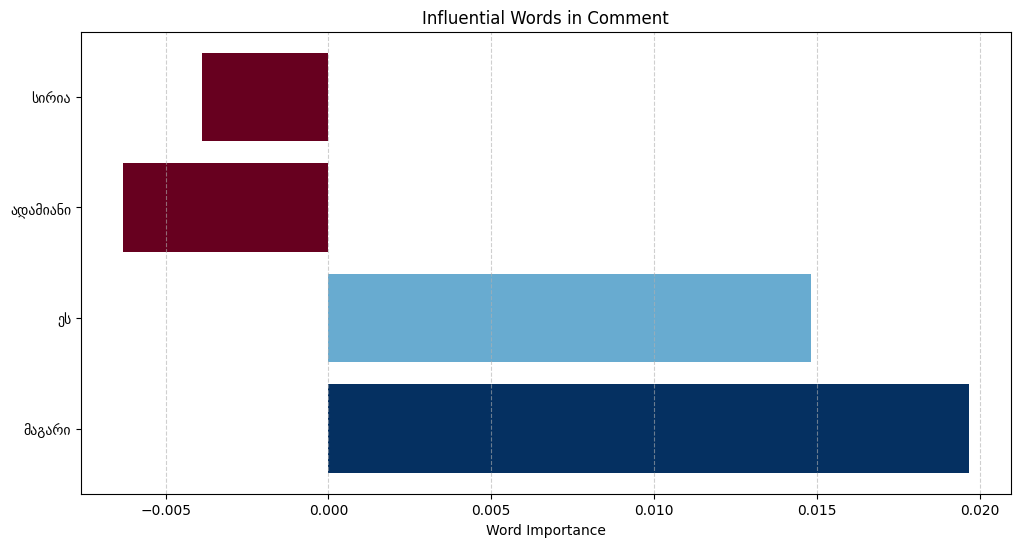

In [150]:
generate_visual_explanation("ეს ადამიანი მაგარი სირია", pipeline, 20)

Intercept 0.6260547617746399
Prediction_local [0.61263873]
Right: 0.6179213167138281


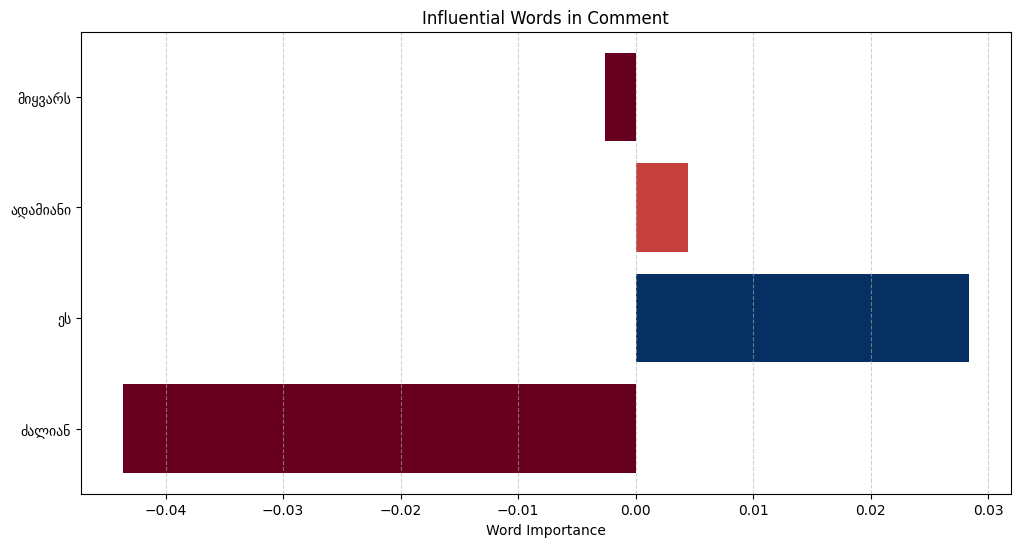

In [149]:
generate_visual_explanation("ეს ადამიანი ძალიან მიყვარს", pipeline, 20)

# Store Trained Model For Inference

In [151]:
!pip install joblib

In [154]:
import joblib

In [155]:
joblib.dump(pipeline, 'tfidf_logreg_classifier.pkl')

['tfidf_logreg_classifier.pkl']